# IQ Mixing notes

https://markimicrowave.com/technical-resources/application-notes/how-to-think-about-iq-mixers/

In [1]:
%matplotlib widget
import niscope as ni

# Uscita trigger dal signal generator: Pulse Sync

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import os
import sys
sys.path.insert(1, '..\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')
sys.path.insert(3, '..\\Instruments\\QuickSyn')
sys.path.insert(4, '..\\HDF5')

import RS_SMA100B
from Card_Class import *
from HDF5 import save_dict_to_hdf5 as hdf5_write


import FSL_0010

fsl = FSL_0010.FSL10_synthesizer(device_address='COM37')

In [2]:
ip              = '192.168.40.15'                                   # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

k = 2                                                               # coefficiente per prendere k*1000 punti 
                                                                    # con la scheda, dunque devo aumentare la pulse width e period

pulse_freq      = 1.010e9
amplitude       = -18                                               # Set the amplitude of the signal in dBm
sample_rate     = 250e6                                             # Maximum Value: 250.0e6
pulse_width     = k * 3e-6                                          # min 5ns                             
pulse_delay     = 1e-6
pulse_period    = k * 5e-6                                          # min 20ns


sGen.reset()
sGen.clear()
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('SING')
sGen.RF_freq(pulse_freq)
sGen.RF_lvl_ampl(amplitude)


# parameters for the Acquisition Card
pxie.voltage_range      = 0.5
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = 1000
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = sample_rate                               # Maximum Value: 250.0e6



SMA100B: Connection successful!
5170R: Available communication!


In [4]:
# FSL-0010
fsl.set_frequency(1) # GHz
fsl.set_output('ON')
pxie.open(trigger_channel = '0')

pota        = np.arange(amplitude, amplitude + 3 , 1)
pula        = np.arange(pulse_freq, pulse_freq + 0.003e9, 0.001e9)

amplidick   = {}
counter     = 1


digits_p = "{:0"+str(len(str(len(pota))))+"d}"
digits_f = "{:0"+str(len(str(len(pula))))+"d}"
for p, pot in enumerate(pota):
    print('- P cycle:', p)
    amplidick[f'p{digits_p.format(p)}'] = {'power_(dBm)': pot, 'freqs': {}}
    sGen.RF_lvl_ampl(pot)

    for i, pul in enumerate(pula):
        
        sGen.RF_freq(pul) # guarda come è definito, abbiamo messo la potenza e6   
        sGen.pul_state(1)
        sGen.RF_state(1)
        # time.sleep(0.1)
        waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
        I = np.array(waveforms[3].samples.tolist())
        Q = np.array(waveforms[2].samples.tolist())
        # if p == 1 and i == 1:
        #   plt.clf()
        #   #plt.plot(np.sqrt(I**2 + Q**2))
        #   plt.plot(np.arctan(Q/I))
        #   plt.show()
        
        
        sGen.pul_state(0)
        sGen.RF_state(0)

        print(int(counter*100/(len(pota)*len(pula))),'%')
        counter += 1
        amplidick[f'p{digits_p.format(p)}']['freqs'][f'f{digits_f.format(i)}'] = {'freq_(Hz)': pul, 'I': I, 'Q': Q}
fsl.set_output('OFF')


# SAVE DATA ON HDF5 FILE
filename = 'amplitrix2_IQMixer.hdf5'
if os.path.exists(filename):
  os.remove(filename)
hdf5_write(amplidick, filename)

- P cycle: 0
11 %
22 %
33 %
- P cycle: 1
44 %
55 %
66 %
- P cycle: 2
77 %
88 %
100 %


In [ ]:








# with ni.Session("PXI1Slot3") as session: # Name of the device
#     session.reset_with_defaults()
#     # session.channels[3].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC) # I
#     # session.channels[2].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC) # Q
#     session.channels[1].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC)

#     session.configure_horizontal_timing(
#         min_sample_rate     = 250e6, 
#         min_num_pts         = int(1000*k), 
#         ref_position        = 0, 
#         num_records         = 1, 
#         enforce_realtime    = True
#         )

#     session.configure_trigger_digital(
#         trigger_source      = 'VAL_PFI_0', 
#         slope               = ni.TriggerSlope.POSITIVE, 
#         holdoff             = 0, 
#         delay               = 0
#         )

#     with session.initiate():
#         #waveforms = session.channels[0, 2].fetch()
#         waveforms = session.channels[1].fetch()
#     for wfm in waveforms:
#         print('Channel {0}, record {1} samples acquired: {2:,}\n'.format(wfm.channel, wfm.record, len(wfm.samples)))
        

# #fsl.set_output('OFF')
# sGen.pul_state(0)
# sGen.RF_state(0)

# # a = np.array(waveforms[0].samples.tolist())
# # b = np.array(waveforms[1].samples.tolist())
# c = np.array(waveforms[0].samples.tolist())

# plt.figure()
# #plt.plot(np.arange(len(a))/250e6, 20*np.log10(np.array(a)**2 + np.array(b)**2))
# #plt.plot(np.arange(len(a))/250e6, np.sqrt(np.array(a)**2 + np.array(b)**2))
# #plt.plot(np.arange(len(a))/250e6, np.arctan(np.array(b)/np.array(a)))
# plt.plot(np.arange(len(c))/250e6, np.array(c))
# plt.show()

In [ ]:
# def weight_factor (ft, range_mask):
#     # tot_int = np.trapz(ft)
#     tot_int = np.sum(ft)
#     ft[~range_mask] = 0
#     # portion = np.trapz(ft)
#     portion = np.sum(ft)

#     return tot_int/portion

# def data_fft(y: np.array, freq, sample_rate, toggle_plot = True):
#     N = len(y)
#     T = 1/sample_rate
#     FT = np.fft.fft(y)
#     PHI = np.unwrap(np.angle(FT))

#     x = np.arange(len(y))/sample_rate
#     freqs = np.fft.fftfreq(N,T) 
#     offset = 5e6

#     if toggle_plot:
#         plt.clf()
        
       
#         plt.plot(freqs,np.abs(FT))
#         plt.show()
    
# data_fft(a, 80e6, sample_rate, True)

- [x] Nel grafico sopra, la frequenza del sig gen è 1,020 GHz. Si notano i due picchetti di 40 = 2 * 20 MHz, ma paiono estremamente piccoli. (Foto sul telefono per il futuro)

Dai test sembra che non servano attenuazioni quando il segnale passa per il mixer, ma è necessaerio capire quanta potenza effettivamente arriva alla scheda per non friggerla.

## DOVREMO fare la CARATTERIZZAZIONE DELL'IQ-MIXER

Studiare range di ampiezze in cui opera e magari anhe range di frequenze.
Studiare Attenuazione che dà?

Nel piano I-q non compare una circonferenza precisa, ma è più un'ellisse. Studiare e magari richiedere.

## LA PRESA DATI PROBABILMENTE SARA' A GIUGNO (2 SETTIMANE CENTRALI)

Preparare i programmi, anche per l'analisi dati in loco per risparmiare tempo.
Relazione su Latex
Giachero dice di premere per fare presa dati a maggio piuttosto che a giugno, ma francamente la vedo dura.
# Sistemare i cicli for nei programmi!! e ritestare il single trigger nei for.

In [ ]:
from HDF5 import load_hdf5_to_dict as hdf5_read
filename = 'amplitrix_IQMixer.hdf5'
data = hdf5_read(filename)
data

{'p0': {'freqs': {'f0': {'I': array([ 9.66869586e-04,  1.03491855e-03,  8.98820617e-04,  9.66869586e-04,
            1.03491855e-03,  9.66869586e-04,  1.10296752e-03,  8.98820617e-04,
            8.98820617e-04,  1.10296752e-03,  8.98820617e-04,  8.98820617e-04,
            1.17101649e-03,  8.98820617e-04,  6.26624744e-04,  9.66869586e-04,
            8.30771649e-04,  6.26624744e-04,  7.62722681e-04,  8.98820617e-04,
            1.17101649e-03,  7.62722681e-04,  8.98820617e-04,  9.66869586e-04,
            1.03491855e-03,  9.66869586e-04,  1.17101649e-03,  9.66869586e-04,
            1.23906546e-03,  1.17101649e-03,  8.30771649e-04,  9.66869586e-04,
            1.10296752e-03,  9.66869586e-04,  9.66869586e-04,  9.66869586e-04,
            9.66869586e-04,  1.03491855e-03,  9.66869586e-04,  9.66869586e-04,
            8.30771649e-04,  9.66869586e-04,  9.66869586e-04,  6.94673712e-04,
            8.30771649e-04,  8.30771649e-04,  6.94673712e-04,  8.30771649e-04,
            9.66869586e-04

In [ ]:
def load_hdf5_to_dict(hdf5_file, group_name=''):
    """
    Legge un file HDF5 salvato dal codice specificato e salva tutto il contenuto in un dizionario.

    :param hdf5_file: percorso al file HDF5
    :param group_name: nome del gruppo da cui iniziare la lettura, se presente
    :return: un dizionario con i dati del file HDF5
    """
    def recursively_load_group_to_dict(h5group):
        dictionary = {}
        for key, item in h5group.items():
            if isinstance(item, h5py.Dataset):
                dictionary[key] = item[()]
            elif isinstance(item, h5py.Group):
                dictionary[key] = recursively_load_group_to_dict(item)
        return dictionary

    with h5py.File(hdf5_file, 'r') as f:
        if group_name:
            group = f[group_name]
        else:
            group = f
        data_dict = recursively_load_group_to_dict(group)
    
    return data_dict

# # Esempio di utilizzo
# hdf5_file_path = 'path/to/your/file.hdf5'
# data = load_hdf5_to_dict(hdf5_file_path)
# print(data)

In [ ]:
dictionary = load_hdf5_to_dict(r'C:\Users\oper\SynologyDrive\Lab2023\Qubit\QTLab2324\PAandQubit\Actual_Work\amplitrix_IQMixer.hdf5')

In [ ]:
I = np.array(dictionary['p0']['freqs']['f0']['I']).reshape(len(dictionary['p0']['freqs']['f0']['I']),1)
Q = np.array(dictionary['p0']['freqs']['f0']['Q']).reshape(len(dictionary['p0']['freqs']['f0']['Q']),1)

In [ ]:
theta = np.arctan(I/Q)
circle = np.hstack([np.cos(theta), np.sin(theta)])
print(I)

[[ 9.66869586e-04]
 [ 1.03491855e-03]
 [ 8.98820617e-04]
 [ 9.66869586e-04]
 [ 1.03491855e-03]
 [ 9.66869586e-04]
 [ 1.10296752e-03]
 [ 8.98820617e-04]
 [ 8.98820617e-04]
 [ 1.10296752e-03]
 [ 8.98820617e-04]
 [ 8.98820617e-04]
 [ 1.17101649e-03]
 [ 8.98820617e-04]
 [ 6.26624744e-04]
 [ 9.66869586e-04]
 [ 8.30771649e-04]
 [ 6.26624744e-04]
 [ 7.62722681e-04]
 [ 8.98820617e-04]
 [ 1.17101649e-03]
 [ 7.62722681e-04]
 [ 8.98820617e-04]
 [ 9.66869586e-04]
 [ 1.03491855e-03]
 [ 9.66869586e-04]
 [ 1.17101649e-03]
 [ 9.66869586e-04]
 [ 1.23906546e-03]
 [ 1.17101649e-03]
 [ 8.30771649e-04]
 [ 9.66869586e-04]
 [ 1.10296752e-03]
 [ 9.66869586e-04]
 [ 9.66869586e-04]
 [ 9.66869586e-04]
 [ 9.66869586e-04]
 [ 1.03491855e-03]
 [ 9.66869586e-04]
 [ 9.66869586e-04]
 [ 8.30771649e-04]
 [ 9.66869586e-04]
 [ 9.66869586e-04]
 [ 6.94673712e-04]
 [ 8.30771649e-04]
 [ 8.30771649e-04]
 [ 6.94673712e-04]
 [ 8.30771649e-04]
 [ 9.66869586e-04]
 [ 7.62722681e-04]
 [ 7.62722681e-04]
 [ 7.62722681e-04]
 [ 8.9882061

In [ ]:
# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.hstack([I**2, I * Q, Q**2, I, Q])
b = np.ones_like(I)
x = np.linalg.lstsq(A, b)[0].squeeze()

C:\Users\oper\AppData\Local\Temp\ipykernel_9856\1553087256.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0].squeeze()


In [ ]:
print(x)

[ 5.31933569e+04 -3.56395773e+04  7.64116774e+04 -8.74515218e+01
 -6.01301952e+01]


In [ ]:
# Plot the noisy data
a = 15
I =  I[a:-a]
Q =  Q[a:-a]
plt.scatter(I[a:-a], Q[a:-a], label='Data Points')

The ellipse is given by 5.32e+04x^2 + -3.56e+04xy+7.64e+04y^2+-87.5x+-60.1y = 1


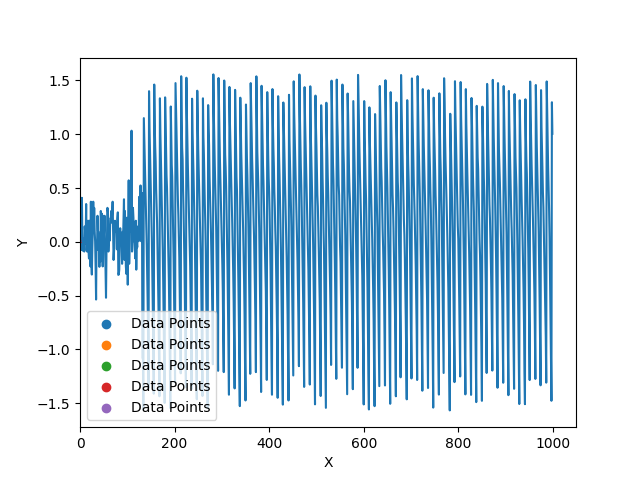

In [ ]:
# Print the equation of the ellipse in standard form
print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(x[0], x[1],x[2],x[3],x[4]))

# Plot the noisy data
plt.scatter(I, Q, label='Data Points')

# Plot the least squares ellipse
y_coord = np.linspace(-0.005,0.005,len(I))
x_coord = np.linspace(-0.005,0.005,len(I))
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()